In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import functools
import pandas as pd
import copy
from networks import *
from hessian_eigenthings import compute_hessian_eigenthings
from pyhessian import hessian, utils
from density_plot import get_esd_plot

torch.set_default_dtype(torch.float64)
%matplotlib inline

In [2]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
    #torch.set_default_tensor_type('torch.cuda.DoubleTensor')

We are going to solve the heat equation with a PINN. Specifically, we solve it for a rectangular domain with the ends being held at a fixed temperature. 

$$
    \nabla^2 u(x, t) = \partial_t u(x, t) \\
    u(0, y, t) = a_1 \\
    u(L, y, t) = a_2 \\
    u(x, 0, t) = u(x, W, t) = 5 sin(\frac{2\pi x}{L} 
    \times freq) + a_1 + (a_2 - a_1)x \\
    u(x, y, 0) = 0 \text{ for } 0 < x < L, \, 0 < y < W

$$

In [3]:
input_dim = 3
output_dim = 1
width = 16
num_hidden_layers = 3
#net = PDE_conv_net(input_dim, output_dim, num_hidden_layers, width)
#net = NAIS_Net_Untied(input_dim, width, num_hidden_layers, output_dim, torch.sin).to(device)
#net = DGM_Net(input_dim, width, num_hidden_layers, output_dim, torch.sin).to(device)
net = DGM_Net(input_dim, width, num_hidden_layers, output_dim, nn.GELU(approximate='none')).to(device)

In [4]:
def generate_boundary_values(a1, a2, L, W, T, N, freq): 
    """[[x, y, t], u(x, y, t)=u(x, y, 0)]"""
    ts = np.linspace(0, T, N)
    
    xs = np.linspace(0, L, N)
    ys = np.linspace(0, W, N)
    
    us_x = 5*np.sin(xs / L * 2 * np.pi * 10) + np.linspace(a1, a2, N)
    us_y_left = np.linspace(a1, a1, N)
    us_y_right = np.linspace(a2, a2, N)
    
    x_data_up = np.concatenate([xs.reshape(-1, 1), W*np.ones(N).reshape(-1, 1), us_x.reshape(-1, 1)], axis=1)
    x_data_down = np.concatenate([xs.reshape(-1, 1), np.zeros(N).reshape(-1, 1), us_x.reshape(-1, 1)], axis=1)

    y_data_left = np.concatenate([np.zeros(N).reshape(-1, 1), ys.reshape(-1, 1), us_y_left.reshape(-1, 1)], axis=1)
    y_data_right = np.concatenate([L*np.ones(N).reshape(-1, 1), ys.reshape(-1, 1), us_y_right.reshape(-1, 1)], axis=1)
    
    data_no_time = np.concatenate([x_data_up, x_data_down, y_data_left, y_data_right])
    data = np.concatenate([np.concatenate([data_no_time, ts[i]*np.ones(len(data_no_time)).reshape(-1, 1)], axis=1) for i in range(len(ts))], axis=0)


    return pd.DataFrame(data, columns=["x", "y", "u", "t"])
    
    

def generate_constraint_points_condition(L, W, T, N):
    xs = np.linspace(0, L, N)
    ys = np.linspace(0, W, N)
    
    XY = np.meshgrid(xs, ys)
    
    ps = np.concatenate([XY[0].flatten().reshape(-1, 1), XY[1].flatten().reshape(-1, 1)], axis=1)
    
    data = np.concatenate([ps, np.zeros(len(ps)).reshape(-1, 1), np.zeros(len(ps)).reshape(-1, 1)], axis=1)
    
    return pd.DataFrame(data, columns=["x", "y", "u", "t"])

def generate_initial_condition(L, W, T, N, eps_x, eps_y):
    xs = np.linspace(eps_x, L - eps_x, N)
    ys = np.linspace(eps_y, W - eps_y, N)

    XY = np.meshgrid(xs, ys)
    ps = np.concatenate([XY[0].flatten().reshape(-1, 1), XY[1].flatten().reshape(-1, 1)], axis=1)
    data = np.concatenate([ps, np.zeros(len(ps)).reshape(-1, 1), np.zeros(len(ps)).reshape(-1, 1)], axis=1)
    return pd.DataFrame(data, columns=["x", "y", "u", "t"])

def get_collocation_points(L, W, T, N):
    """Uniform sampling of collocation points"""
    xs = np.linspace(0, L, N)
    ys = np.linspace(0, W, N)
    ts = np.linspace(0, T, N)
    XYT = np.meshgrid(xs, ys, ts)
    data = np.concatenate([x.flatten().reshape(-1, 1) for x in XYT], axis=1)
    return pd.DataFrame(data, columns=["x", "y", "t"])

def get_collocation_points_interior(L, W, T, N, eps_x, eps_y, eps_t):
    """Uniform sampling of collocation points"""
    xs = np.linspace(eps_x, L - eps_x, N)
    ys = np.linspace(eps_y, W - eps_y, N)
    ts = np.linspace(eps_t, T, N)
    XYT = np.meshgrid(xs, ys, ts)
    data = np.concatenate([x.flatten().reshape(-1, 1) for x in XYT], axis=1)
    return pd.DataFrame(data, columns=["x", "y", "t"])

# Generate data

In [5]:
a1 = 0
a2 = 5
Nb = 50
Ni = 50
W = 1
L = 1
freq = 2

T = 1
eps = 1e-3

# x,y rectangle
boundary = generate_boundary_values(a1, a2, L, W, T, Nb, freq)
# t=0
#initial = generate_constraint_points_condition(L, W, T, Ni)
initial = generate_initial_condition(L, W, T, Ni, eps, eps)

constraint_points = pd.concat([boundary, initial])
#collocation_points = get_collocation_points(L, W, T, Ni)
collocation_points = get_collocation_points_interior(L, W, T, Ni, eps, eps, eps)

In [6]:
collocation_points

,x,y,t
0,0.001,0.001,0.001000
1,0.001,0.001,0.021388
2,0.001,0.001,0.041776
3,0.001,0.001,0.062163
4,0.001,0.001,0.082551
...,...,...,...
124995,0.999,0.999,0.918449
124996,0.999,0.999,0.938837
124997,0.999,0.999,0.959224
124998,0.999,0.999,0.979612


# PINN Adam

In [7]:
def grad_getter(inp, out):
    return torch.autograd.grad(inputs=inp, outputs=out, 
                    grad_outputs=torch.ones_like(out),
                    retain_graph=True, create_graph=True
                   )

def loss_int(net, X):
    u = net(X)
    x, y, t = X[:, 0], X[:, 1], X[:, 2]

    du_dX = grad_getter(X, u)[0]

    du_dx, du_dy, du_dt = du_dX.T

    du_dxX = grad_getter(X, du_dx)[0]
    du_dxx, du_dxy, du_dxt = du_dxX.T

    du_dyX = grad_getter(X, du_dy)[0]
    du_dyx, du_dyy, du_dyt = du_dyX.T

    Du = du_dxx + du_dyy - du_dt
    return torch.mean(Du**2)

def loss_b(net, X, bs):
    u = net(X).flatten()
    return torch.mean((u - bs)**2)

def loss_closure(net, opt, X, Xb, bvs):
    opt.zero_grad()
    X.grad = None
    
    loss = loss_int(net, X) + 100*loss_b(net, Xb, bvs)
    loss.backward()
    #print(float(loss))
    return loss

In [8]:
X = torch.tensor(collocation_points[["x", "y", "t"]].values, device=device, requires_grad=True)
Xb, bvs = torch.tensor(constraint_points[["x", "y", "t"]].values, device=device), torch.tensor(constraint_points["u"].values, device=device)

In [15]:
learning_rate = 1e-3
epochs = 66000
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [16]:
losses = []
losses_grad = []
epoch = 0
while epoch < epochs:
    optimizer.zero_grad()
    X.grad = None   
    loss = loss_int(net, X) + 100*loss_b(net, Xb, bvs)
    loss.backward()
    grads = []
    for param in net.parameters():
        grads.append(param.grad.view(-1))
    grads = torch.cat(grads)
    losses_grad.append(grads)
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item()}, grad norm: {grads.detach().norm().item()}")
    losses.append(loss.item())
    epoch += 1

Epoch: 0, loss: 1272.0554403249755, grad norm: 464.9243306681398
Epoch: 100, loss: 593.1285183909355, grad norm: 72.29347282470911
Epoch: 200, loss: 557.8016869492758, grad norm: 29.6447726148334
Epoch: 300, loss: 517.4231488219345, grad norm: 121.669144598435
Epoch: 400, loss: 511.7765443995874, grad norm: 24.211287570657095
Epoch: 500, loss: 509.54213776431885, grad norm: 88.28918103635606
Epoch: 600, loss: 507.48170523104267, grad norm: 66.08812787805248
Epoch: 700, loss: 506.5969624821275, grad norm: 1144.0669134569573
Epoch: 800, loss: 504.32791499113364, grad norm: 8.85682263309648
Epoch: 900, loss: 503.53554576345016, grad norm: 50.717779881297766
Epoch: 1000, loss: 502.94386041368904, grad norm: 32.61126062549084
Epoch: 1100, loss: 502.5932528224245, grad norm: 70.68700745183682
Epoch: 1200, loss: 502.35111183972964, grad norm: 194.97998547899041
Epoch: 1300, loss: 502.110353227182, grad norm: 7.543521839489916
Epoch: 1400, loss: 501.9291617456926, grad norm: 55.37557587305464


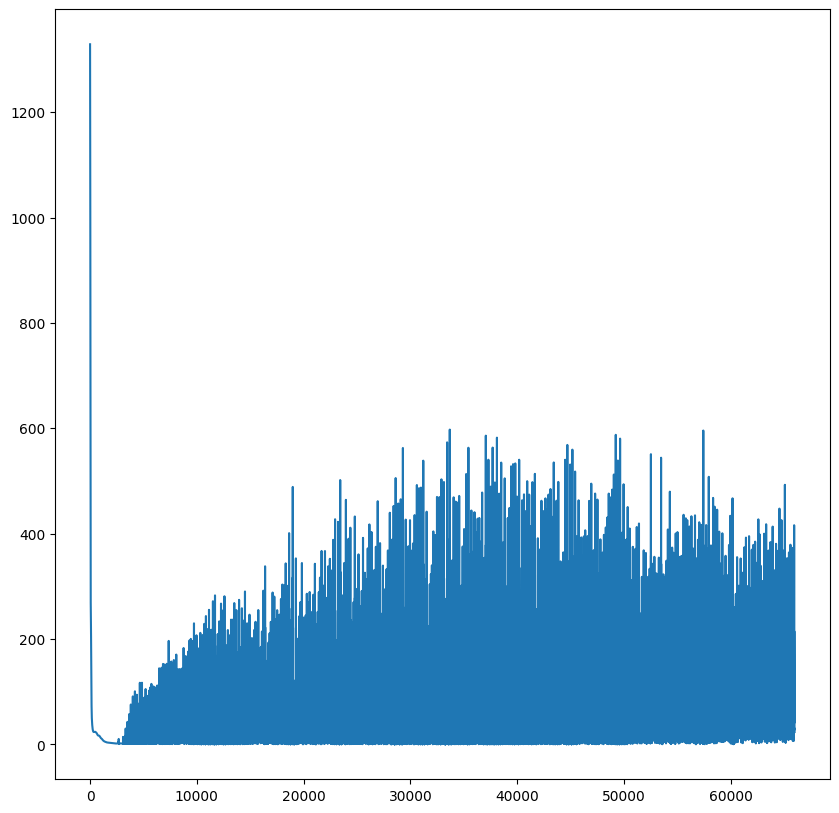

In [13]:
losses_grad_norm = [torch.norm(grad).cpu().numpy() for grad in losses_grad]
plt.figure(figsize=(10, 10))
plt.plot(losses_grad_norm)
plt.show()

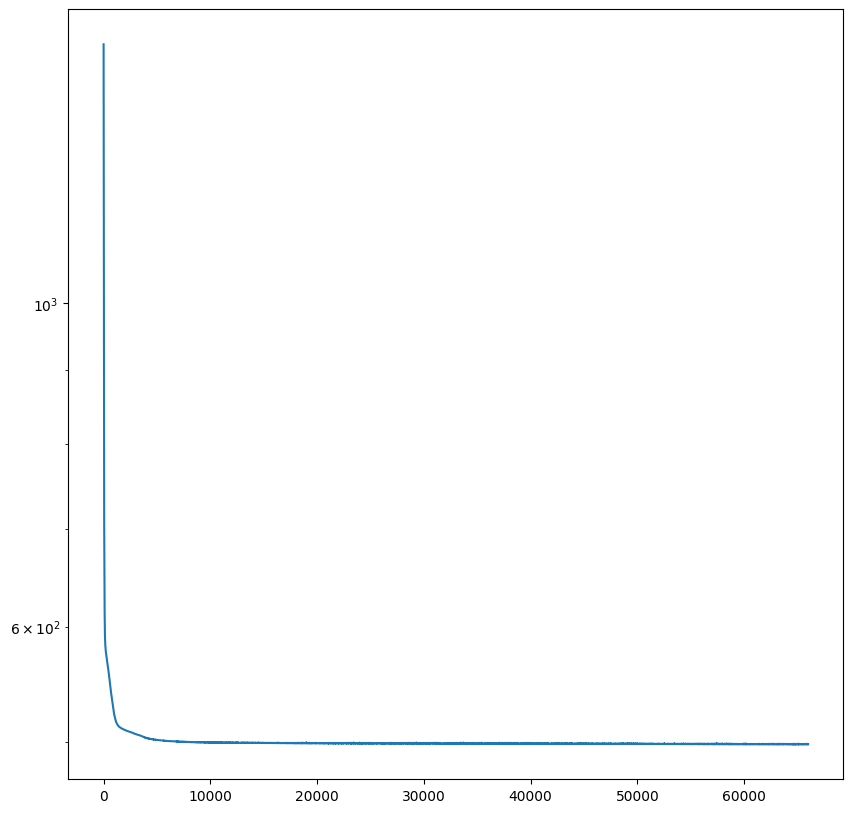

In [14]:
plt.figure(figsize=(10, 10))
plt.yscale("log")
plt.plot(losses)

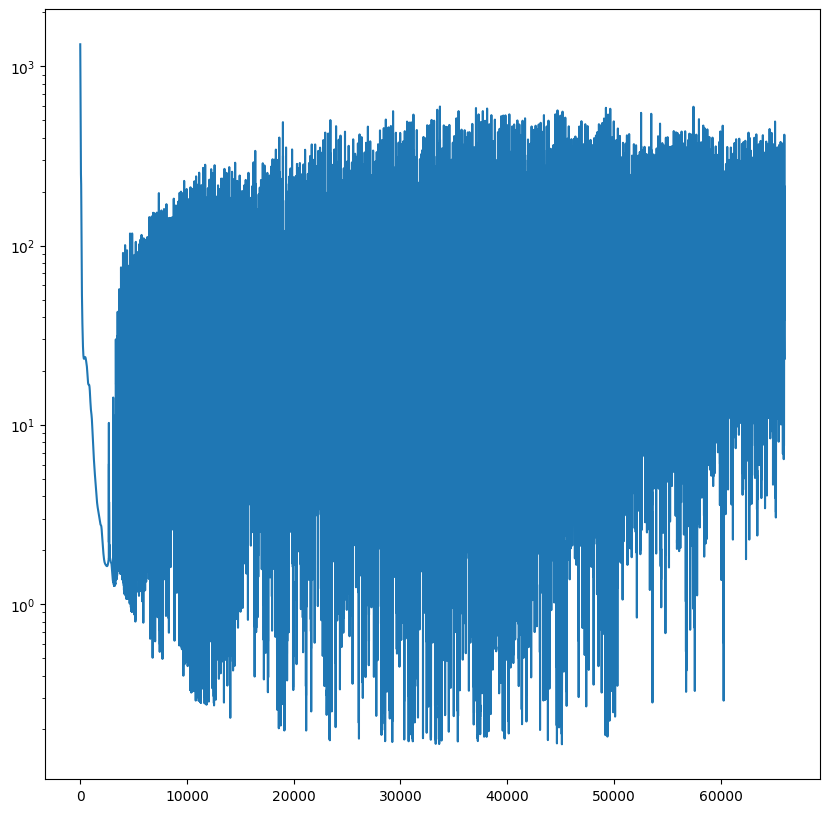

In [15]:
# plot grad norm on log scale
plt.figure(figsize=(10, 10))
plt.yscale("log")
plt.plot(losses_grad_norm)

In [17]:
torch.save(net.state_dict(), "model.pth")

In [19]:
net = NAIS_Net_Untied(input_dim, width, num_hidden_layers, output_dim, torch.sin).to(device)
net.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [20]:
lambda_2 = 100
boundary_data = torch.cat((torch.ones((len(constraint_points), 1), device=device), torch.tensor(constraint_points[["x", "y", "t", "u"]].values, device=device)), dim=-1)
collocation_data = torch.zeros((len(collocation_points), len(["x", "y", "t", "u"])+1), device=device)
collocation_data[:, 1:-1] = torch.tensor(collocation_points[["x", "y", "t"]].values)
combined_data = torch.cat((boundary_data, collocation_data), dim=0)
combined_dataset = torch.utils.data.TensorDataset(combined_data[:, :-1], combined_data[:, [0, -1]])
combined_loader = torch.utils.data.DataLoader(combined_dataset, batch_size=10, shuffle=False, generator=torch.Generator(device=device))
#https://discuss.pytorch.org/t/compute-grad-with-regard-a-slice-of-the-input/172823

In [21]:
class PINN_wrapper(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.net = net
    
    def forward(self, X):
        boundary_bool = X[:, 0] > 0
        X_b = X[boundary_bool, 1:]
        X_i = X[~boundary_bool, 1:]
        X_i.requires_grad = True

        boundary_output = self.net(X_b)
        interior_output = self.net(X_i)

        return boundary_output, X_i, interior_output
    

def loss_int_criterion(X, u):
    x, y, t = X[:, 0], X[:, 1], X[:, 2]

    du_dX = grad_getter(X, u)[0]

    du_dx, du_dy, du_dt = du_dX.T

    du_dxX = grad_getter(X, du_dx)[0]
    du_dxx, du_dxy, du_dxt = du_dxX.T

    du_dyX = grad_getter(X, du_dy)[0]
    du_dyx, du_dyy, du_dyt = du_dyX.T

    Du = du_dxx + du_dyy - du_dt
    return torch.mean(Du**2)

def loss_b_criterion(u, bs):
    return torch.mean((u - bs)**2)


#def loss_dataloader(wrapper_outputs, targets):
    #boundary_outputs, X_int, interior_outputs = wrapper_outputs
    #boundary_targets = targets[targets[:, 0] > 0, 1]

    #loss = loss_int_dataloader(X_int, interior_outputs) + 100*loss_b_dataloader(boundary_outputs, boundary_targets)
    
    #return loss

def losses_criterion(wrapper_outputs, targets):
    boundary_outputs, X_int, interior_outputs = wrapper_outputs
    boundary_targets = targets[targets[:, 0] > 0, 1]

    loss_int = loss_int_criterion(X_int, interior_outputs)
    loss_b = loss_b_criterion(boundary_outputs, boundary_targets)
    loss = loss_int + 100*loss_b

    return loss, loss_int, loss_b

def loss_criterion(wrapper_outputs, targets):
    loss, _, _ = losses_criterion(wrapper_outputs, targets)
    return loss

def loss_boundary_criterion(wrapper_outputs, targets):
    _, _, loss_b = losses_criterion(wrapper_outputs, targets)
    return loss_b

def loss_differential_data_criterion(wrapper_outputs, targets):
    loss_int, _, _ = losses_criterion(wrapper_outputs, targets)
    return loss_int

In [22]:
num_parameters = sum(p.numel() for p in net.parameters())
num_eigenthings = num_parameters
#eigenvals, eigenvecs = compute_hessian_eigenthings(PINN_wrapper(net).to(device), combined_loader, loss_criterion, num_eigenthings)

In [25]:
total = combined_data.shape[0]
indices = np.random.choice(total, 10000, replace=False)

In [26]:
#hessian_comp = hessian(PINN_wrapper(net), loss_criterion, data=(combined_data[:, :-1], combined_data[:, [0, -1]]), cuda=True)
hessian_comp = hessian(PINN_wrapper(net), loss_criterion, data=(combined_data[indices, :-1], combined_data[indices][:, [0, -1]]), cuda=True)
trace = np.mean(hessian_comp.trace())
density_eigen, density_weight = hessian_comp.density()

c:\Users\Rahil\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\autograd\__init__.py:200: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ..\torch\csrc\autograd\engine.cpp:1156.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [19]:
print(f"Trace: {trace}")

Trace: 35510.538852438825


In [20]:
eigenvalues = density_eigen[0]
eigenvalues = np.array([x.real for x in eigenvalues])
print(np.min(eigenvalues), np.max(eigenvalues))

-1081.3942893372546 16011.347370033136


c:\Users\Rahil\PDE-Project\density_plot.py:63: ComplexWarning: Casting complex values to real discards the imaginary part
  density_output[i, j] = np.sum(tmp_result * weights[i, :])
c:\Users\Rahil\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\Rahil\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\transforms.py:2860: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


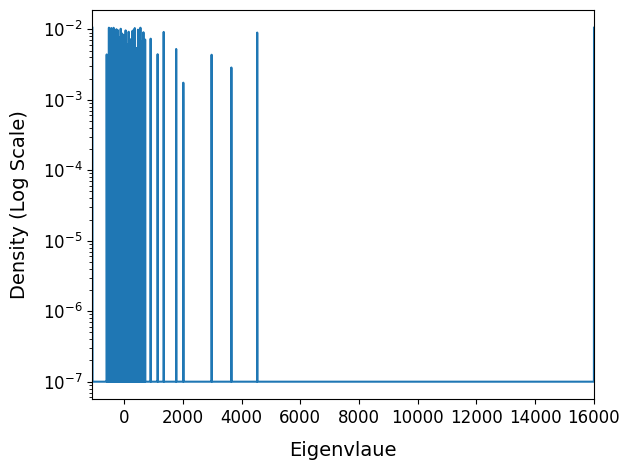

In [21]:
get_esd_plot(density_eigen, density_weight)

In [22]:
num_parameters = sum(p.numel() for p in net.parameters())
#eigenvals, eigenvecs = hessian_comp.eigenvalues(top_n=num_parameters)
import time
start_time = time.time()
eigenvals, eigenvecs = hessian_comp.eigenvalues(top_n=25)
total_time = time.time() - start_time
total_time

63.205400705337524

In [23]:
min_eig_index = np.argmin(eigenvals)
min_eigenval = eigenvals[min_eig_index]
min_eigenvec = eigenvecs[min_eig_index]
max_eig_index = np.argmax(eigenvals)
max_eigenval = eigenvals[max_eig_index]
max_eigenvec = eigenvecs[max_eig_index]

In [24]:
def perturb_params(net_orig, net_pert, pert_direction, pert_size):
    for param_orig, param_pert, param_pert_direction in zip(net_orig.parameters(), net_pert.parameters(), pert_direction):
        param_pert.data = param_orig.data + pert_size * param_pert_direction

In [30]:
net_copy = copy.deepcopy(net)
alphas = torch.linspace(-1, 1, 101, device=device)
losses_min_eig = []
losses_max_eig = []
for alpha in alphas:
    perturb_params(net, net_copy, min_eigenvec, alpha)
    losses_min_eig.append([t.detach().cpu().numpy() for t in losses_criterion(PINN_wrapper(net_copy)(combined_data[:, :-1]), combined_data[:, [0, -1]])])
    perturb_params(net, net_copy, max_eigenvec, alpha)
    losses_max_eig.append([t.detach().cpu().numpy() for t in losses_criterion(PINN_wrapper(net_copy)(combined_data[:, :-1]), combined_data[:, [0, -1]])])
losses_min_eig = np.array(losses_min_eig)
losses_max_eig = np.array(losses_max_eig)
alphas = alphas.detach().cpu().numpy()

In [38]:
def plot_losses(steps, losses_array, min_max, loss_type, scale):
    plt.figure(figsize=(10, 10))
    plt.plot(steps, losses_array)
    plt.title(f"{loss_type} loss after perturbing parameters by the {min_max} eigenvector")
    plt.xlabel("Step size")
    if scale == "log":
        plt.yscale("log")
    plt.ylabel("{loss_type} loss")
    #plt.show()
    plt.savefig(f"{loss_type}_loss_{min_max}_eig.png")

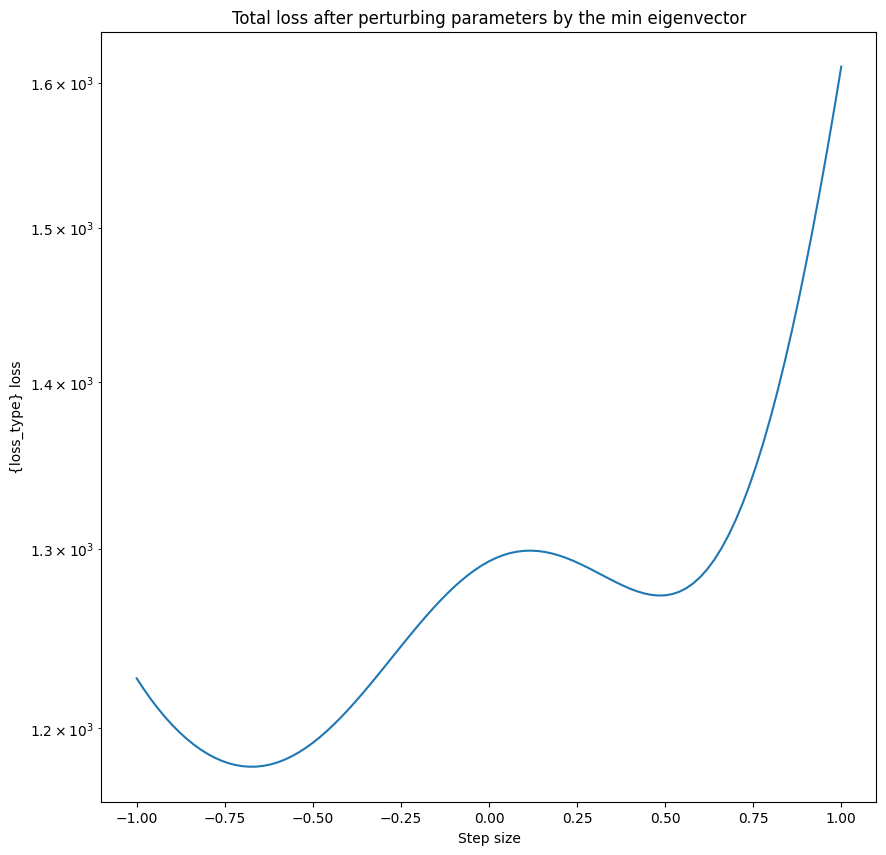

In [39]:
plot_losses(alphas, losses_min_eig[:, 0], "min", "Total", "log")

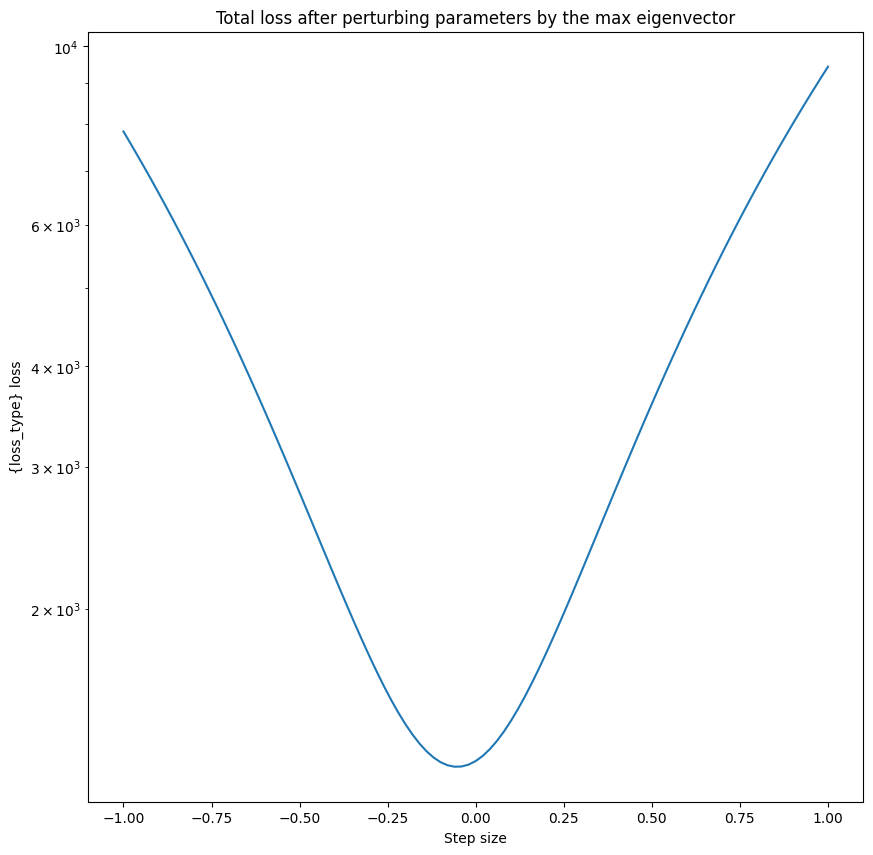

In [40]:
plot_losses(alphas, losses_max_eig[:, 0], "max", "Total", "log")

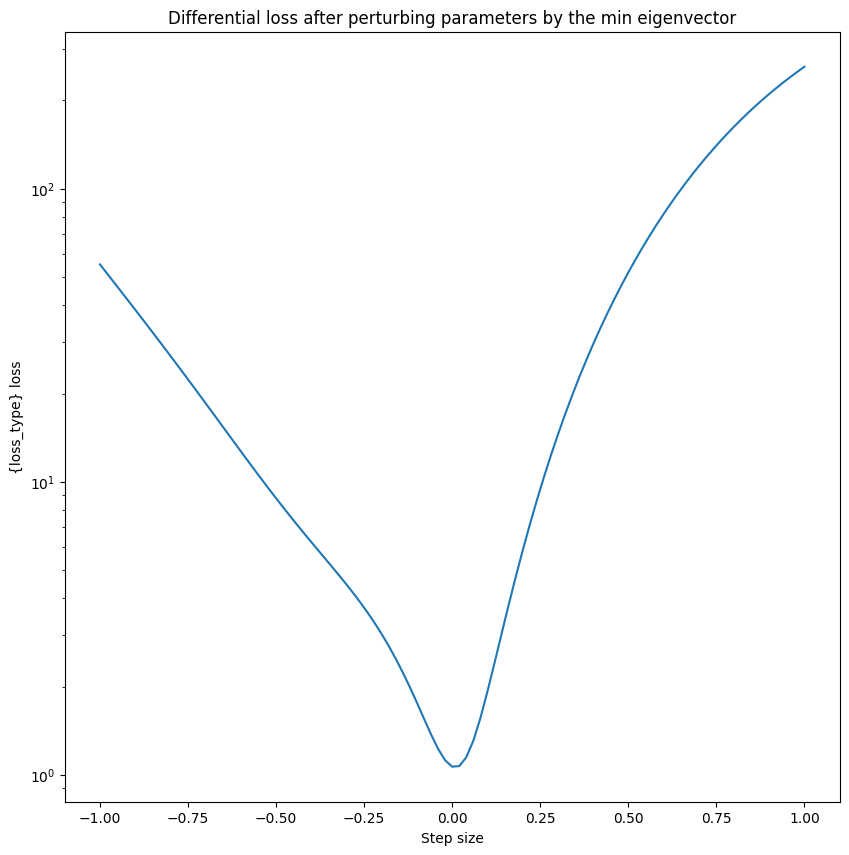

In [41]:
plot_losses(alphas, losses_min_eig[:, 1], "min", "Differential", "log")

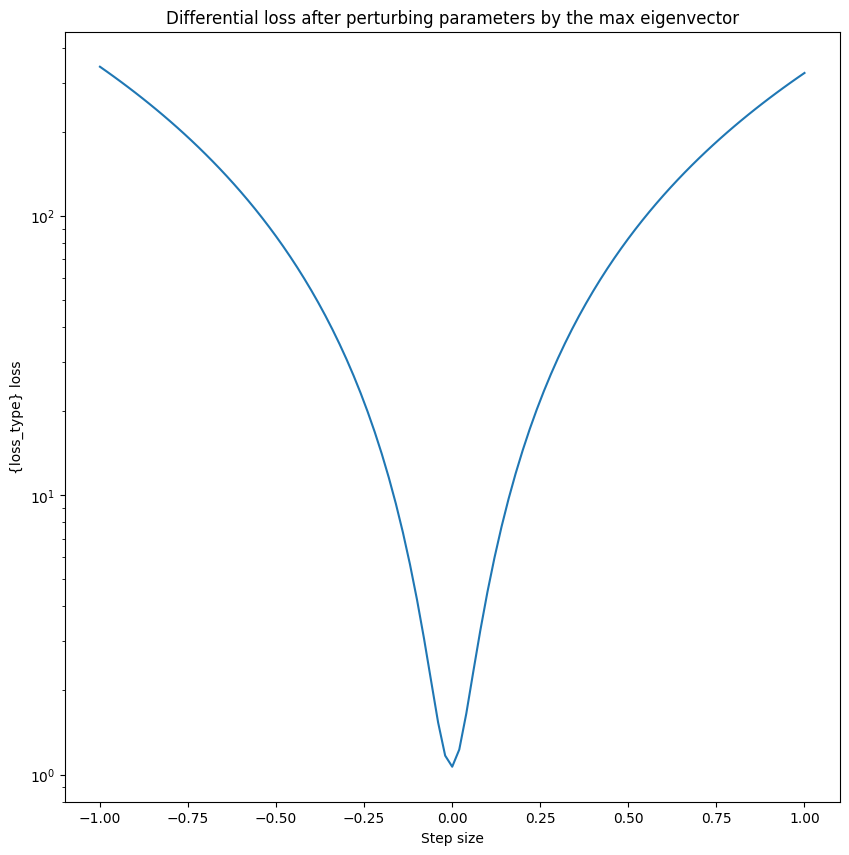

In [42]:
plot_losses(alphas, losses_max_eig[:, 1], "max", "Differential", "log")

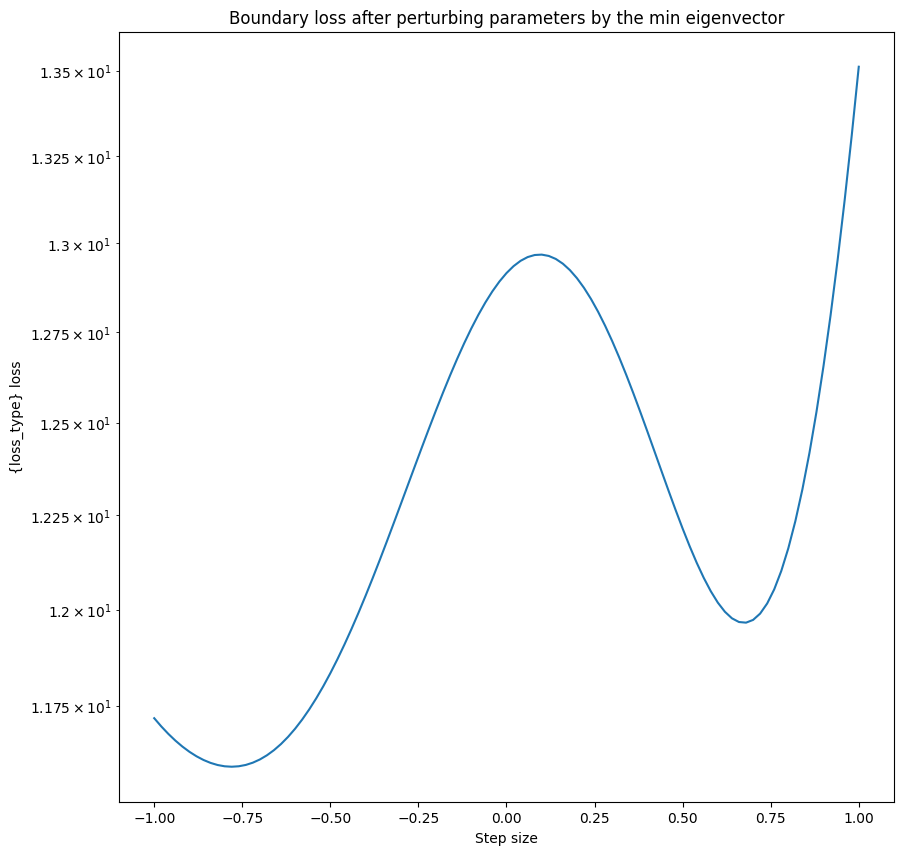

In [43]:
plot_losses(alphas, losses_min_eig[:, 2], "min", "Boundary", "log")

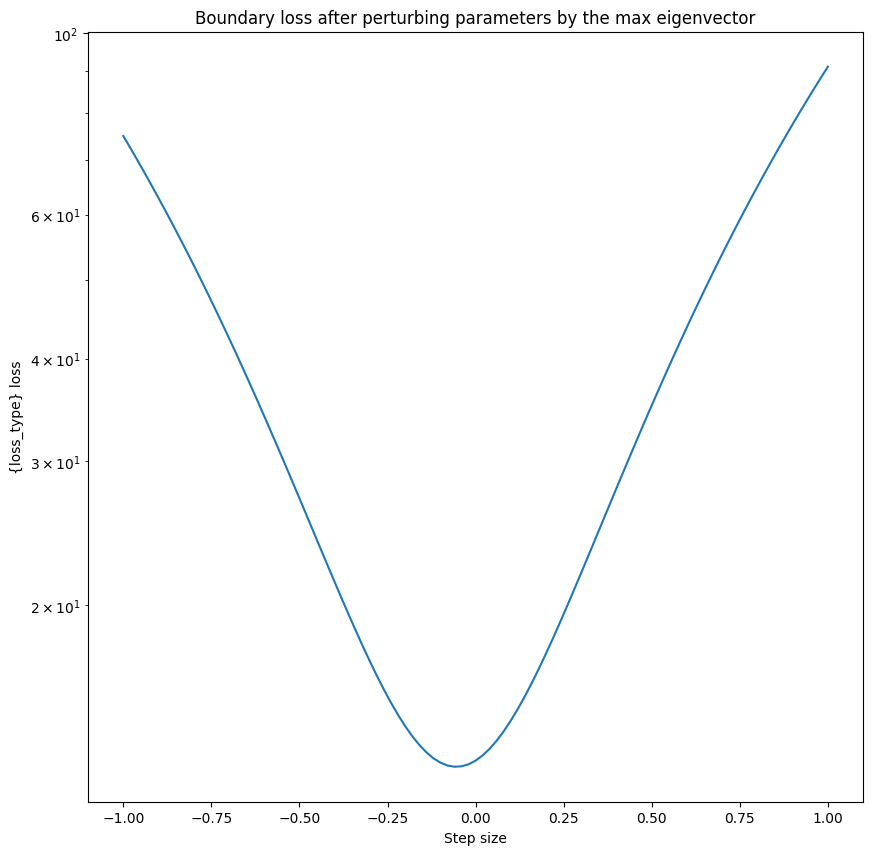

In [44]:
plot_losses(alphas, losses_max_eig[:, 2], "max", "Boundary", "log")

In [60]:
net.zero_grad()
boundary_loss = loss_b(net, Xb, bvs)
boundary_loss.backward()
boundary_grad = torch.cat([p.grad.flatten() for p in net.parameters()]).detach()
print(boundary_loss)
print(boundary_grad)
print(torch.norm(boundary_grad))
net.zero_grad()
differential_loss = loss_int(net, X)
print(differential_loss)
differential_loss.backward()
differential_grad = torch.cat([p.grad.flatten() if p.grad is not None else torch.zeros_like(p) for p in net.parameters()]).detach()
print(differential_grad)
print(torch.norm(differential_grad))

tensor(5.0466, grad_fn=<MeanBackward0>)
tensor([ 0.0009, -0.0011, -0.0006,  ..., -0.0001, -0.0014,  0.0002])
tensor(0.0720)
tensor(1.0667, grad_fn=<MeanBackward0>)
tensor([-0.0990,  0.1267,  0.0781,  ...,  0.0225,  0.0962,  0.0000])
tensor(7.1943)


In [29]:
hessian_comp.gradsH

[tensor([[  -9.1654,   -4.7703,   -2.7924],
         [ 227.4235,   12.3188,   63.5592],
         [ -33.0011,    7.8565,   -6.9400],
         [   8.5795,   11.0209,   -1.7819],
         [ -91.0861,  -73.5680,   -8.0959],
         [  31.0776, -102.7277,   11.0027],
         [  36.6538,   -3.2589,   10.7076],
         [  63.2758,   91.5475,   43.0749],
         [ -52.2452,  -16.9686,  -21.6499],
         [ -30.5970,    1.5573,   -5.7712],
         [  13.6034,    5.5794,    4.1574],
         [  70.2158,  -14.4414,   28.1573],
         [  -4.6774,  -15.3576,    3.5921],
         [ -10.0316,    5.3332,   -4.1915],
         [  47.4950,   27.8597,   10.9624],
         [  29.2465,  -22.6133,   12.8245]], grad_fn=<AddBackward0>),
 tensor([   9.5985,   18.2587,   17.3166,   21.4619, -143.7531, -172.1581,
           -7.0165,  177.2335,  -28.8972,    2.2453,    8.9893,  -36.0305,
          -27.4112,    9.9543,   56.8310,  -35.2623], grad_fn=<AddBackward0>),
 tensor([[-7.9741e+00, -7.1260e+00,  1.53

In [42]:
#hessian_comp.dataloader_hv_product(hessian_comp.gradsH)
Hg = utils.hessian_vector_product(hessian_comp.gradsH, hessian_comp.params, hessian_comp.gradsH)
utils.group_product(Hg, hessian_comp.gradsH)

tensor(1.5643e+10, grad_fn=<AddBackward0>)

# PINN LBFGS

In [12]:
optimizer = torch.optim.LBFGS(
            net.parameters(), 
            lr=1, 
            max_iter=5000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
optimizer.step(lambda : loss_closure(net, optimizer, X, Xb, bvs))

OutOfMemoryError: CUDA out of memory. Tried to allocate 246.00 MiB (GPU 0; 8.00 GiB total capacity; 7.19 GiB already allocated; 0 bytes free; 7.26 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Boundary (rectangle) only as regression problem

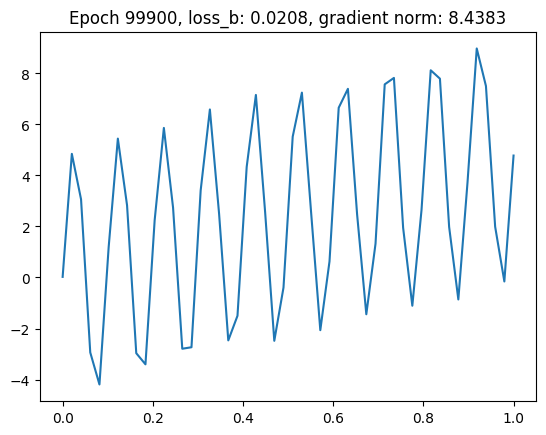

In [10]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

# 2 hidden layers in each net
boundary_net = NAIS_Net_Untied(input_dim, width, 4, output_dim, torch.sin).to(device)
epochs_1 = 100000
learning_rate_1 = 1e-3
losses_border = []
losses_grad_border = []
# train boundary net
boundary_optimizer = torch.optim.Adam(boundary_net.parameters(), lr=learning_rate_1)
for epoch in range(epochs_1):
    boundary_optimizer.zero_grad()
    rectangle = Xb[:, 1] == 0.
    boundary_loss = loss_b(boundary_net, Xb[rectangle], bvs[rectangle])
    boundary_loss.backward()
    boundary_optimizer.step()
    losses_border.append(boundary_loss.item())
    with torch.no_grad():
        grads = []
        for param in boundary_net.parameters():
            grads.append(param.grad.detach().view(-1).to(device="cpu"))
        grads = torch.cat(grads)
        losses_grad_border.append(torch.norm(grads).item())
    if epoch % 100 == 0:
        N = 50
        xs = np.linspace(0, L, N)
        ys = np.linspace(0, W, N)
        inp = torch.tensor(np.concatenate([xs.reshape(-1, 1), np.zeros((len(xs), 1)), 1*np.ones((len(xs), 1))], axis=1))
        out = boundary_net(inp)

        clear_output(wait=True)
        plt.title("Epoch %d, loss_b: %.4f, gradient norm: %.4f" % (epoch, boundary_loss.item(), torch.norm(grads).item()))
        plt.plot(xs, out.detach().cpu().numpy(), label="Neural net")
        if epoch % 1000 == 0:
            plt.savefig(f"plots/rectangle_border_{epoch}.png")
        plt.show()
plt.show()


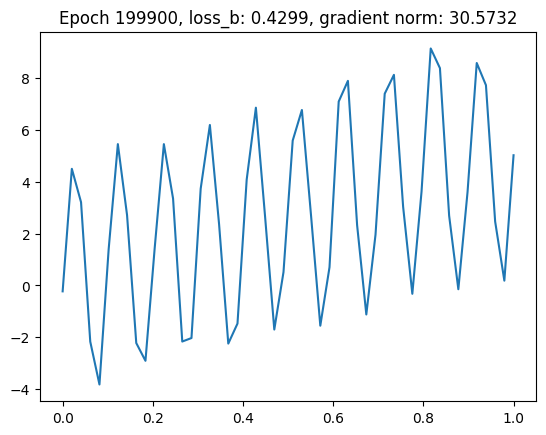

In [17]:
#plot is for top and bottom rectangle border but trained on all constraint points
# 2 hidden layers in each net
boundary_net = NAIS_Net_Untied(input_dim, width, 4, output_dim, torch.sin).to(device)
epochs_1 = 200000
learning_rate_1 = 5e-3
losses_b = []
losses_grad_b = []
# train boundary net
boundary_optimizer = torch.optim.Adam(boundary_net.parameters(), lr=learning_rate_1)
for epoch in range(epochs_1):
    boundary_optimizer.zero_grad()
    boundary_loss = loss_b(boundary_net, Xb, bvs)
    boundary_loss.backward()
    boundary_optimizer.step()
    losses_b.append(boundary_loss.item())
    with torch.no_grad():
        grads = []
        for param in boundary_net.parameters():
            grads.append(param.grad.detach().view(-1).to(device="cpu"))
        grads = torch.cat(grads)
        losses_grad_b.append(torch.norm(grads).item())
    if epoch % 100 == 0:
        #print('Epoch %d, loss_b: %.4f' % (epoch, boundary_loss.item()))
        N = 50
        xs = np.linspace(0, L, N)
        ys = np.linspace(0, W, N)
        inp = torch.tensor(np.concatenate([xs.reshape(-1, 1), np.zeros((len(xs), 1)), 1*np.ones((len(xs), 1))], axis=1))
        out = boundary_net(inp)

        clear_output(wait=True)
        plt.title("Epoch %d, loss_b: %.4f, gradient norm: %.4f" % (epoch, boundary_loss.item(), torch.norm(grads).item()))
        plt.plot(xs, out.detach().cpu().numpy(), label="Neural net")
        if epoch % 1000 == 0:
            plt.savefig(f"plots/boundary_{epoch}_lr_{learning_rate_1}.png")
        plt.show()
plt.show()

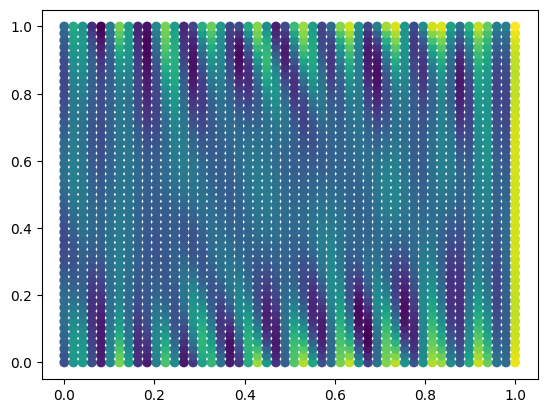

In [31]:
N = 50
xs = np.linspace(0, L, N)
ys = np.linspace(0, W, N)
XY = np.meshgrid(xs, ys)
pts_XY = np.concatenate([x.flatten().reshape(-1, 1) for x in XY], axis=1)
pts = np.concatenate([pts_XY, 0.*np.ones(len(pts_XY)).reshape(-1, 1)], axis=1)

out = boundary_net(torch.tensor(pts, device=device))
plt.scatter(pts_XY[:, 0], pts_XY[:, 1], c=out.detach().cpu().numpy())

# Training with the numerical solution data

In [84]:
from scipy.signal import convolve2d

In [85]:
def generate_boundary_values_numerical(a1, a2, L, W, N, freq): 
    
    xs = np.linspace(0, L, N)
    ys = np.linspace(0, W, N)
    
    us_x = 5*np.sin(xs / L * 2 * np.pi * freq) + np.linspace(a1, a2, N)
    us_y_left = np.linspace(a1, a1, N)
    us_y_right = np.linspace(a2, a2, N)
    
    D = np.zeros((N, N))
    D[:, 0] = us_y_left
    D[:, -1] = us_y_right
    
    D[0, :] = us_x
    D[-1, :] = us_x
    return D

In [86]:
a1 = 0
a2 = 5
N = 25
W = 1
L = 1
T = 0.1
print(freq)
Nt = 10000

hx = 1/N
ht = T/Nt

boundary = generate_boundary_values_numerical(a1, a2, L, W, N, freq)
#initial = generate_initial_condition_numerical(L, W, N)

U_curr = boundary

In [87]:
conv_filter = 1/hx**2 * np.array([[0, 1, 0],
                                 [1, -4, 1],
                                 [0, 1, 0]])
res = [U_curr]
for t in range(Nt):
    U_next = U_curr + ht * convolve2d(U_curr, conv_filter, mode='same')
    U_next[:, 0] = 0
    U_next[:, -1] = 0
    U_next[0, :] = 0
    U_next[-1, :] = 0
    U_next += boundary
    
    res.append(U_next)
    U_curr = U_next

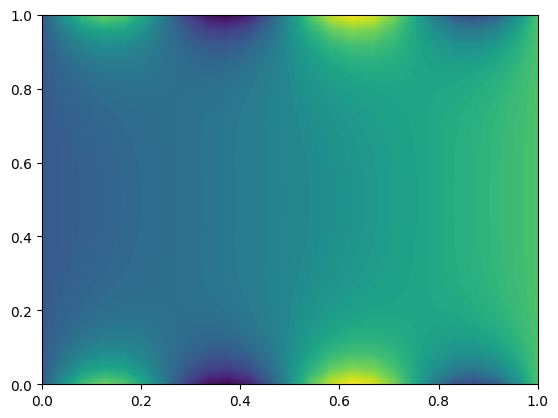

In [88]:
xs = np.linspace(0, L, N)
ys = np.linspace(0, W, N)
XY = np.meshgrid(xs, ys)
XY = np.meshgrid(xs, ys)
plt.contourf(XY[0], XY[1], res[-1], levels = 100)

In [89]:
dataset = []
for i in range(len(res)):
    dataset.append(np.concatenate([XY[0].flatten().reshape(-1, 1), XY[1].flatten().reshape(-1, 1), i*ht * np.ones((N, N)).reshape(-1, 1), res[0].flatten().reshape(-1, 1)], axis=1))
dataset = np.concatenate(dataset, axis=0)
dataset = pd.DataFrame(dataset, columns=["x", "y", "t", "u"])

In [90]:
dataset

,x,y,t,u
0,0.000000,0.0,0.0,0.000000
1,0.041667,0.0,0.0,2.708333
2,0.083333,0.0,0.0,4.746794
3,0.125000,0.0,0.0,5.625000
4,0.166667,0.0,0.0,5.163460
...,...,...,...,...
6250620,0.833333,1.0,0.1,-0.163460
6250621,0.875000,1.0,0.1,-0.625000
6250622,0.916667,1.0,0.1,0.253206
6250623,0.958333,1.0,0.1,2.291667


In [97]:
dataset_tensor = torch.utils.data.TensorDataset(torch.tensor(dataset[["x", "y", "t"]].values), torch.tensor(dataset["u"].values, device=torch.device("cpu")))
dataset_loader = torch.utils.data.DataLoader(dataset_tensor, batch_size=512, shuffle=True)

In [98]:
def loss_reg_criterion(pred, target):
    return torch.mean((pred - target)**2)

In [99]:
regression_net = NAIS_Net_Untied(input_dim, width, 4, output_dim, torch.sin).to(device)
epochs = 10000
learning_rate = 5e-4
losses = []
optimizer = torch.optim.Adam(regression_net.parameters(), lr=learning_rate)
for epoch in range(epochs):
    for inp, target in dataset_loader:
        optimizer.zero_grad()
        inp = inp.to(device)
        target = target.to(device)
        pred = regression_net(inp).view(-1)
        loss = loss_reg_criterion(pred, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if epoch % 1 == 0:
        print('Epoch %d, loss: %.4f' % (epoch, loss.item()))

Epoch 0, loss: 0.9159
Epoch 1, loss: 1.4081
Epoch 2, loss: 0.5748


# Starting forward stepper network (unfinished)

In [17]:
class PDE_conv_net(nn.Module):
    def __init__(self, input_dim, output_dim, num_hidden_layers, linear_size, channels):
        super(PDE_conv_net, self).__init__()
        
        self.activation = torch.tanh
        self.linear_size = linear_size
        self.linear_size_sqrt = int(np.sqrt(linear_size))
        self.upsample_linear_layers = nn.ModuleList([nn.Linear(input_dim, self.linear_size)] + [nn.Linear(self.linear_size, self.linear_size) for _ in range(num_hidden_layers)])
        self.deconv_kernel_size = 2
        self.deconv_stride = 2
        self.deconv_padding = 1
        self.channels = channels
        self.deconv_layer = nn.ModuleList([nn.ConvTranspose2d(1, self.channels, kernel_size=self.deconv_kernel_size, stride=self.deconv_stride, padding=self.deconv_padding) for _ in range(num_hidden_layers)])
        self.grid_size = self.linear_size_sqrt
        for _ in range(num_hidden_layers):
            self.grid_size = (self.grid_size - 1) * self.deconv_stride + self.deconv_kernel_size - 2 * self.deconv_padding
        print(f"latent grid size is {self.grid_size}x{self.grid_size}")
        self.conv_layers = nn.ModuleList([nn.Conv2d(self.channels, self.channels, kernel_size=3, stride=1, padding=1) for _ in range(num_hidden_layers)])
        self.conv_u_linear_layer = nn.Linear(self.grid_size * self.grid_size * self.channels, output_dim)

    def upsample(self, x):
        for i in range(len(self.upsample_linear_layers)):
            x = self.activation(self.upsample_linear_layers[i](x))
        x = x.view(-1, 1, self.linear_size_sqrt, self.linear_size_sqrt)
        return x
    
    def deconv(self, x):
        for i in range(len(self.deconv_layer)):
            x = self.activation(self.deconv_layer[i](x))
        return x
    
    def conv(self, x):
        for i in range(len(self.conv_layers)):
            x = self.activation(self.conv_layers[i](x))
        return x

    def embed(self, x):
        x = self.upsample(x)
        x = self.deconv(x)
        return x
    
    def forward_step(self, x):
        x = self.conv(x)
        u = x.view(-1, self.grid_size * self.grid_size * self.channels)
        u = self.conv_u_linear_layer(u)
        return x, u

In [189]:
# choose N >  3
def forward_sequence(net, X_initial, T, N):
    ts = torch.linspace(0, T, N + 1, device=device)
    X_latent = net.embed(X_initial)
    us = []
    for i in range(N + 1):
        X_latent, u = net.forward_step(X_latent)
        us.append(u)
    return ts, us

def loss_sequence_boundary(net, X_initial, ts, us, us_true):
    us_tensor = torch.stack(us)
    loss = torch.sum((us_tensor - us_true.unsqueeze(dim=-1))**2, dim=-1).mean()
    return loss
    
def loss_sequence_interior(net, X_initial, ts, us):
    loss = torch.sum(us[0].flatten()**2)
    for i in range(2, len(us)):
        du_dt = ((us[i] - us[i-1]) / (ts[i] - ts[i-1])).squeeze()
        du_dX = grad_getter(X_initial, us[i])[0]
        du_dx = du_dX[:, 0]
        du_dy = du_dX[:, 1]
        du_dxX = grad_getter(X_initial, du_dx)[0]
        du_dyX = grad_getter(X_initial, du_dy)[0]
        du_dxx = du_dxX[:, 0]
        du_dyy = du_dyX[:, 1]
        #print(f"du_dyy shape: {du_dyy.shape}")
        Du = du_dxx + du_dyy - du_dt
        loss += torch.sum(Du**2)
    loss = loss / us.shape[0]
    return loss

def loss_combined(net, data, Xu, T, N):
    condition = data[:, 0] > 0
    X_interior = data[~condition, 1:-1]
    X_boundary = data[condition, 1:-1]
    us_b_true = data[condition, -1]
    ts_b, us_b = forward_sequence(net, X_boundary, T, N)
    ts_i, us_i = forward_sequence(net, X_interior, T, N)
    loss = loss_sequence_boundary(net, X_boundary, ts_b, us_b, us_b_true) + loss_sequence_interior(net, X_interior, ts_i, us_i)
    return loss

def loss_sequence(net, boundary_data, interior_data, T, N):
    X_boundary = boundary_data[:, :-1]
    us_b_true = boundary_data[:, -1]
    ts_b, us_b = forward_sequence(net, X_boundary, T, N)
    ts_i, us_i = forward_sequence(net, interior_data, T, N)
    loss = loss_sequence_boundary(net, X_boundary, ts_b, us_b, us_b_true) + loss_sequence_interior(net, interior_data, ts_i, us_i)
    return loss

# full batch training
def train_adam_combined(net, data, T, N, epochs, learning_rate):
    optimizer = torch.optim.adam(net.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        optimizer.zero_grad()
        data.grad = None
        loss = loss_combined(net, data, T, N)
        loss.backward()
        optimizer.step()
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, loss {loss.item()}")

def train_adam(net, boundary_data, interior_data, T, N, epochs, learning_rate):
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        optimizer.zero_grad()

        # boundary loss
        boundary_loss = 0
        X_boundary = boundary_data[:, :-1]
        us_b_true = boundary_data[:, -1]
        X_latent = net.embed(X_boundary)
        for i in range(N + 1):
            X_latent, u = net.forward_step(X_latent)
            boundary_loss += torch.sum((u - us_b_true.unsqueeze(dim=-1))**2)
        boundary_loss = boundary_loss / X_boundary.shape[0]

        # interior loss
        delta_t = T / N
        interior_loss = 0
        X_interior = interior_data.detach().clone().requires_grad_(True)
        X_latent = net.embed(X_interior)
        X_latent, u_0 = net.forward_step(X_latent)
        interior_loss += torch.sum(u_0.flatten()**2)
        X_latent, u_1 = net.forward_step(X_latent)
        for i in range(2, N + 1):
            #print(f"beep {epoch}, {i}")
            u_0 = u_1
            X_latent, u_1 = net.forward_step(X_latent)
            du_dt = (u_1 - u_0).squeeze() / delta_t
            du_dX = grad_getter(X_interior, u_1)[0]
            du_dx = du_dX[:, 0]
            du_dy = du_dX[:, 1] 
            du_dxX = grad_getter(X_interior, du_dx)[0]
            du_dyX = grad_getter(X_interior, du_dy)[0]
            du_dxx = du_dxX[:, 0]
            du_dyy = du_dyX[:, 1]
            Du = du_dxx + du_dyy - du_dt
            interior_loss += torch.sum(Du**2)
        interior_loss = interior_loss / X_interior.shape[0]

        loss = boundary_loss + interior_loss
        loss.backward()
        optimizer.step()
        print(f"Epoch: {epoch}, loss: {loss.item()}")

In [190]:
pde_step_net = PDE_conv_net(2, 1, 2, 4**2, 1)

latent grid size is 10x10


In [152]:
# x,y rectangle from earlier
boundary_data = torch.tensor(boundary[boundary["t"]==0][["x", "y", "u"]].values, device=device, requires_grad=True)
interior_data = torch.tensor(initial[["x", "y"]].values, device=device, requires_grad=True)

In [191]:
indices = np.random.choice(len(interior_data), 32, replace=False)
train_adam(pde_step_net, boundary_data[:], interior_data[indices], 1, 25, 10000, 1e-3)

KeyboardInterrupt: 

In [176]:
interior_dataset = torch.utils.data.TensorDataset(interior_data)
boundary_dataset = torch.utils.data.TensorDataset(boundary_data[:, :-1], boundary_data[:, -1])
interior_dataloader = torch.utils.data.DataLoader(interior_dataset, batch_size=25, shuffle=True, generator=torch.Generator(device=device))
boundary_dataloader = torch.utils.data.DataLoader(boundary_dataset, batch_size=25, shuffle=True, generator=torch.Generator(device=device))
epochs = 5000
N = 25
learning_rate = 1e-3
optimizer = torch.optim.Adam(pde_step_net.parameters(), lr=learning_rate)

In [194]:
for epoch in range(epochs):
    for interior_sample, boundary_sample in zip(interior_dataloader, boundary_dataloader):
        optimizer.zero_grad()
        # interior sample is a list of one element, the tensor
        interior_sample = interior_sample[0]
        boundary_sample, us_b_true = boundary_sample
        
        # boundary loss
        boundary_loss = 0
        X_latent = pde_step_net.embed(boundary_sample)
        for i in range(N + 1):
            X_latent, u = pde_step_net.forward_step(X_latent)
            boundary_loss += torch.sum((u - us_b_true.unsqueeze(dim=-1))**2)
        boundary_loss = boundary_loss / boundary_sample.shape[0]

        # interior loss
        delta_t = T / N
        interior_loss = 0
        X_latent = pde_step_net.embed(interior_sample)
        X_latent, u_0 = pde_step_net.forward_step(X_latent)
        interior_loss += torch.sum(u_0.flatten()**2)
        X_latent, u_1 = pde_step_net.forward_step(X_latent)
        for i in range(2, N + 1):
            #print(f"beep {epoch}, {i}")
            u_0 = u_1
            X_latent, u_1 = pde_step_net.forward_step(X_latent)
            du_dt = (u_1 - u_0).squeeze() / delta_t
            print((u_1 - u_0).view(-1))
            du_dX = grad_getter(interior_sample, u_1)[0]
            du_dx = du_dX[:, 0]
            du_dy = du_dX[:, 1] 
            du_dxX = grad_getter(interior_sample, du_dx)[0]
            du_dyX = grad_getter(interior_sample, du_dy)[0]
            du_dxx = du_dxX[:, 0]
            du_dyy = du_dyX[:, 1]
            Du = du_dxx + du_dyy - du_dt
            interior_loss += torch.sum(Du**2)
        interior_loss = interior_loss / interior_sample.shape[0]

        loss = boundary_loss + interior_loss
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, loss {loss.item()}, boundary loss {boundary_loss.item()}, interior loss {interior_loss.item()}")

tensor([0.0635, 0.0636, 0.0634, 0.0638, 0.0636, 0.0639, 0.0638, 0.0632, 0.0632,
        0.0632, 0.0638, 0.0632, 0.0633, 0.0633, 0.0634, 0.0632, 0.0639, 0.0634,
        0.0639, 0.0638, 0.0635, 0.0637, 0.0634, 0.0635, 0.0635],
       grad_fn=<ViewBackward0>)
tensor([-0.0169, -0.0170, -0.0169, -0.0170, -0.0169, -0.0170, -0.0169, -0.0169,
        -0.0169, -0.0169, -0.0170, -0.0169, -0.0169, -0.0169, -0.0169, -0.0169,
        -0.0170, -0.0169, -0.0170, -0.0169, -0.0169, -0.0169, -0.0169, -0.0169,
        -0.0169], grad_fn=<ViewBackward0>)
tensor([0.0043, 0.0043, 0.0043, 0.0043, 0.0043, 0.0043, 0.0043, 0.0044, 0.0044,
        0.0044, 0.0043, 0.0044, 0.0044, 0.0044, 0.0043, 0.0044, 0.0043, 0.0044,
        0.0043, 0.0043, 0.0043, 0.0043, 0.0043, 0.0043, 0.0043],
       grad_fn=<ViewBackward0>)
tensor([0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0011, 0.0011,
        0.0011, 0.0012, 0.0011, 0.0011, 0.0011, 0.0012, 0.0011, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0

KeyboardInterrupt: 

# Plotting

In [61]:
net = regression_net

In [62]:
N = 50

xs = np.linspace(0, L, N)
ys = np.linspace(0, W, N)

XY = np.meshgrid(xs, ys)
pts_XY = np.concatenate([x.flatten().reshape(-1, 1) for x in XY], axis=1)
pts = np.concatenate([pts_XY, 0.2*np.ones(len(pts_XY)).reshape(-1, 1)], axis=1)

In [63]:
out = net(torch.tensor(pts, device=device))

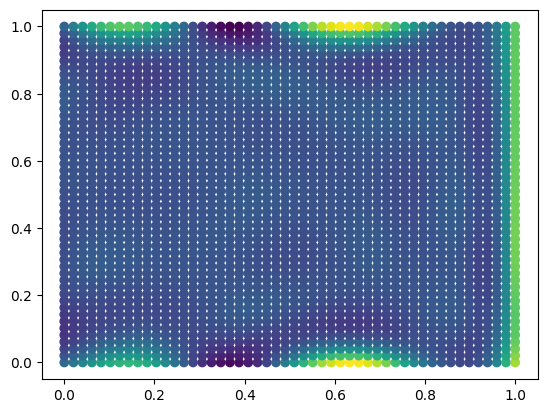

In [64]:
plt.scatter(pts_XY[:, 0], pts_XY[:, 1], c=out.detach().cpu().numpy())

In [83]:
len(XY[0])

50

In [74]:
out.view(50, 50).shape

torch.Size([50, 50])

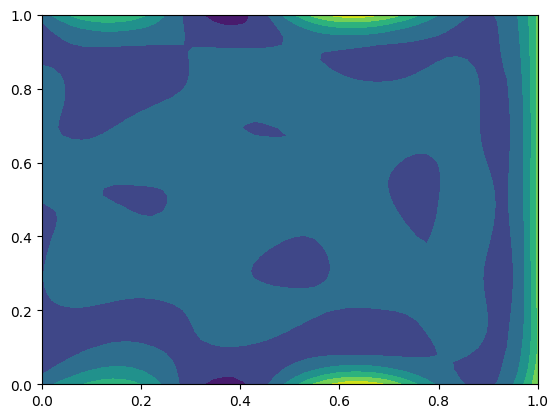

In [79]:
plt.contourf(XY[0], XY[1], out.detach().cpu().view(len(XY[0]), len(XY[1])).numpy())

Plotting boundary

In [18]:
inp = torch.tensor(np.concatenate([xs.reshape(-1, 1), np.zeros((len(xs), 1)), 1*np.ones((len(xs), 1))], axis=1))

out = net(inp)

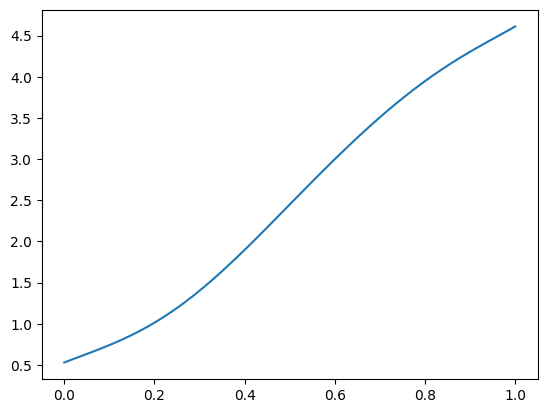

In [19]:
plt.plot(xs, out.detach().cpu().numpy())

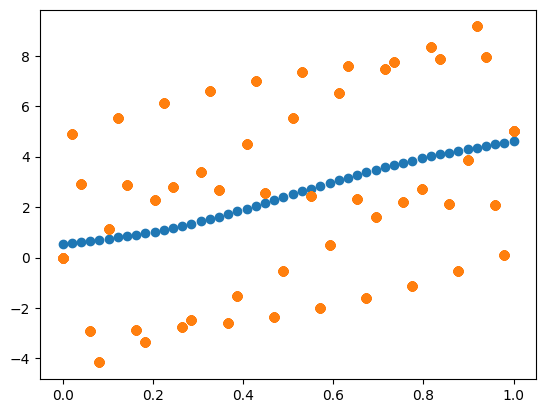

In [20]:
plt.scatter(xs, out.detach().cpu().numpy())
plt.scatter(boundary[boundary["y"]==0]["x"], boundary[boundary["y"]==0]["u"])

In [183]:
inp = torch.tensor(np.concatenate([xs.reshape(-1, 1), np.zeros((len(xs), 1)), 1*np.ones((len(xs), 1))], axis=1))

tensor([[0.0000, 0.0000, 1.0000],
        [0.0204, 0.0000, 1.0000],
        [0.0408, 0.0000, 1.0000],
        [0.0612, 0.0000, 1.0000],
        [0.0816, 0.0000, 1.0000],
        [0.1020, 0.0000, 1.0000],
        [0.1224, 0.0000, 1.0000],
        [0.1429, 0.0000, 1.0000],
        [0.1633, 0.0000, 1.0000],
        [0.1837, 0.0000, 1.0000],
        [0.2041, 0.0000, 1.0000],
        [0.2245, 0.0000, 1.0000],
        [0.2449, 0.0000, 1.0000],
        [0.2653, 0.0000, 1.0000],
        [0.2857, 0.0000, 1.0000],
        [0.3061, 0.0000, 1.0000],
        [0.3265, 0.0000, 1.0000],
        [0.3469, 0.0000, 1.0000],
        [0.3673, 0.0000, 1.0000],
        [0.3878, 0.0000, 1.0000],
        [0.4082, 0.0000, 1.0000],
        [0.4286, 0.0000, 1.0000],
        [0.4490, 0.0000, 1.0000],
        [0.4694, 0.0000, 1.0000],
        [0.4898, 0.0000, 1.0000],
        [0.5102, 0.0000, 1.0000],
        [0.5306, 0.0000, 1.0000],
        [0.5510, 0.0000, 1.0000],
        [0.5714, 0.0000, 1.0000],
        [0.591

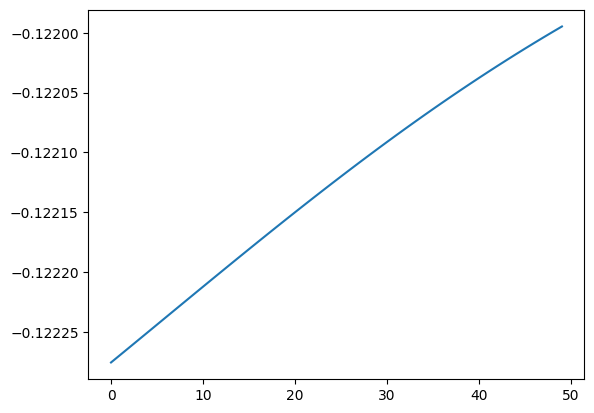

In [185]:
inpu = torch.tensor(np.concatenate([xs.reshape(-1, 1), np.zeros((len(xs), 1))], axis=1))
X_latent = pde_step_net.embed(inpu)
X_latent, u = pde_step_net.forward_step(X_latent)
X_latent, u = pde_step_net.forward_step(X_latent)
plt.plot(u.detach().cpu().numpy())